In [52]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data=pd.read_csv('/content/drive/Shareddrives/540 Project/data/imputed.csv')
target = ['EURWH_MBOE','OilEURWH_MBBL','GasEURWH_BCF']

X = data[[column for column in data.columns if column not in target]]
y = data['EURWH_MBOE']

In [4]:
class WellsDataset (Dataset):
    def __init__(self, features, labels):
        self.features = features.astype(np.float64)
        self.labels = labels.astype(np.float64)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return {'features': torch.tensor(self.features[idx, :]), 'labels': torch.tensor(self.labels[idx]).unsqueeze(-1)}

In [5]:
scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5)

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

train_set = WellsDataset(X_train, y_train)
val_set = WellsDataset(X_val, y_val)
test_set = WellsDataset(X_test, y_test)

trainloader = torch.utils.data.DataLoader(train_set,batch_size=64)
valloader = torch.utils.data.DataLoader(val_set,batch_size=64)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64)

In [6]:
print("Number of training batches = ",len(trainloader))
print("Number of validation batches = ",len(valloader))
print("Number of test batches = ",len(testloader))

Number of training batches =  207
Number of validation batches =  26
Number of test batches =  26


In [7]:
sample = next(iter(trainloader))

print(sample["features"].shape)
print(sample["labels"].shape)

torch.Size([64, 49])
torch.Size([64, 1])


In [47]:
class FiveLayerFC(nn.Module):

    def __init__(self, input_size, hidden_size,lr,wd):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(in_features = input_size, out_features = hidden_size, bias=True),
            nn.ReLU(),
            nn.Linear(in_features = hidden_size, out_features = hidden_size, bias=True),
            nn.ReLU(),
            nn.Linear(in_features = hidden_size, out_features = hidden_size, bias=True),
            nn.ReLU(),
            nn.Linear(in_features = hidden_size, out_features = hidden_size, bias=True),
            nn.ReLU(),
            nn.Linear(in_features = hidden_size, out_features = 1, bias=True),
            nn.ReLU()
        )

        nn.init.xavier_uniform_(self.net[0].weight)
        nn.init.xavier_uniform_(self.net[2].weight)
        nn.init.xavier_uniform_(self.net[4].weight)
        nn.init.xavier_uniform_(self.net[6].weight)
        nn.init.xavier_uniform_(self.net[8].weight)

        nn.init.zeros_(self.net[0].bias)
        nn.init.zeros_(self.net[2].bias)
        nn.init.zeros_(self.net[4].bias)
        nn.init.zeros_(self.net[6].bias)
        nn.init.zeros_(self.net[8].bias)

        self.lr = lr
        self.wd = wd

    def forward(self, x):
        return self.net(x)

    def loss(self,yhat,y):
        return nn.functional.mse_loss(yhat, y)

    def predict(self,x):
        return self.forward(x)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr = self.lr, weight_decay = self.wd)

In [48]:
lr = 1e-3
wd = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device is: ', device)

def test_FiveLayerFC(lr,wd):
    input_size = 49
    x = torch.zeros((64, input_size), dtype=torch.float).to(device)
    model = FiveLayerFC(input_size, 100, lr,wd).to(device)
    outputs = model(x)
    print(outputs.size())

test_FiveLayerFC(lr,wd)

Device is:  cuda
torch.Size([64, 1])


In [49]:
def train_model(model,trainloader,valloader,num_epochs,device,verbose=True):

  # send model to GPU
  model = model.to(device)

  # initialize train loss and val loss tensors for for plotting
  train_loss = torch.empty(num_epochs)
  val_loss = torch.empty(num_epochs)

  # configure optimizer for model
  optimizer = model.configure_optimizers()

  for epoch in range(num_epochs):

    if verbose:
      print("Epoch: ", (epoch + 1), "/", num_epochs)

    # initialize a running train loss and a running val loss
    epoch_train_loss = 0
    epoch_val_loss = 0

    # training loop
    for sample in trainloader:

      trainX = sample['features']
      trainy = sample['labels']

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize step
      loss = model.loss(model(trainX.to(device)), trainy.to(device))
      loss.backward()
      optimizer.step()

      # accumulate running train loss with loss
      epoch_train_loss += loss / len(trainloader)

    with torch.no_grad():

      # validation loop
      for sample in valloader:

        valX = sample['features']
        valy = sample['labels']

        # get loss on validation data
        loss = model.loss(model(valX.to(device)), valy.to(device))

        # accumulate running validation loss with loss
        epoch_val_loss += loss / len(valloader)

    # save accumulated train/val loss
    train_loss[epoch] = epoch_train_loss
    val_loss[epoch] = epoch_val_loss

    if verbose:
      print("Train Loss: ", epoch_train_loss.item())
      print("Validation Loss: ", epoch_val_loss.item())
      print()

  return model, train_loss, val_loss

In [53]:
def model_eval(model,testloader):
    with torch.no_grad():
        ys=[]
        outputs=[]
        for i, tdata in enumerate(testloader):
            tX,ty = tdata["features"], tdata["labels"]
            tX=tX.to(device)
            ty=ty.to(device)
            output = model.predict(tX)
            ys.append(ty.detach().cpu().numpy())
            outputs.append(output.detach().cpu().numpy())

    ys=np.vstack(ys)
    outputs= np.vstack(outputs)

    rmse = np.sqrt(((ys - outputs) ** 2).mean())
    nrmse = np.sqrt(((ys - outputs) ** 2).mean()) / ys.mean(axis = 0)
    r2 = 1 - (1 - r2_score(ys, outputs))*(len(ys) - 1) / (len(ys) - 49 - 1)

    print("RMSE:", rmse)
    print("NRMSE:", nrmse)
    print("Adjust R^2:", r2)

In [56]:
num_epochs = 25

for hidden_size in [100, 250, 500]:
  for lr in [1e-4, 1e-3, 1e-2, 1e-1]:
    for wd in [1e-7, 1e-6, 1e-5]:
      print("Evaluating model with hidden size =", hidden_size, "learning rate =", lr, "and weight decay =", wd)
      model = FiveLayerFC(49,hidden_size,lr,wd)
      model.double()
      model,train_loss,val_loss = train_model(model,trainloader,valloader,num_epochs,device,verbose=False)
      model_eval(model,testloader)
      print()

Evaluating model with hidden size = 100 learning rate = 0.0001 and weight decay = 1e-07
RMSE: 508.1928833501394
NRMSE: [0.48027497]
Adjust R^2: 0.4019842641193184

Evaluating model with hidden size = 100 learning rate = 0.0001 and weight decay = 1e-06
RMSE: 503.28741372021005
NRMSE: [0.47563899]
Adjust R^2: 0.41347356155835857

Evaluating model with hidden size = 100 learning rate = 0.0001 and weight decay = 1e-05
RMSE: 506.1608521911803
NRMSE: [0.47835457]
Adjust R^2: 0.40675708625265306

Evaluating model with hidden size = 100 learning rate = 0.001 and weight decay = 1e-07
RMSE: 494.4791849476771
NRMSE: [0.46731465]
Adjust R^2: 0.4338239639599998

Evaluating model with hidden size = 100 learning rate = 0.001 and weight decay = 1e-06
RMSE: 499.0893804655324
NRMSE: [0.47167158]
Adjust R^2: 0.42321745065767824

Evaluating model with hidden size = 100 learning rate = 0.001 and weight decay = 1e-05
RMSE: 496.68040235456095
NRMSE: [0.46939494]
Adjust R^2: 0.4287719798178109

Evaluating mod

In [64]:
model = FiveLayerFC(49,500,1e-4,1e-6)
model.double()
model,train_loss,val_loss = train_model(model,trainloader,valloader,num_epochs,device,verbose=False)
model_eval(model,testloader)

RMSE: 486.46148303278426
NRMSE: [0.4597374]
Adjust R^2: 0.4520355638309367


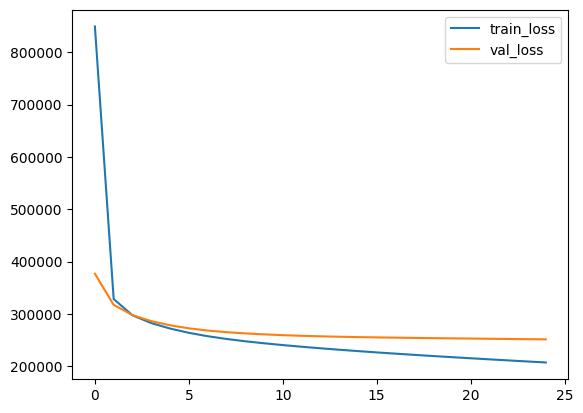

In [65]:
plt.plot(torch.arange(num_epochs),train_loss.detach().numpy(), label="train_loss")
plt.plot(torch.arange(num_epochs),val_loss.detach().numpy(), label="val_loss")
plt.legend()